# House Sales in King County, USA

Predicting house prices using exploratory data analysis and regression models.

This is a cleaned, portfolio-ready version of the original IBM project notebook. It focuses on your analysis and code, and removes platform-specific boilerplate.

## 1. Dataset

This notebook uses the **King County house sales dataset** with missing values (`kc_house_data_NaN.csv`).

- Original source (IBM Developer Skills Network):  
  `kc_house_data_NaN.csv` from the course *Data Analysis with Python*  
- Direct download URL:  
  `https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/kc_house_data_NaN.csv`

To make the notebook easy to run for anyone:

1. You can either **download the CSV manually** and place it in a local `data/` folder, or
2. Let the notebook **download it automatically** from the URL if the local file is not found.


## 2. Setup

Import the libraries used throughout the analysis and configure the environment.

In [1]:
# Suppress non-critical warnings (optional)
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline


## 3. Data loading and initial inspection

The code below:

1. Defines the direct **online URL** of the dataset
2. Looks for a local copy at `data/kc_house_data_NaN.csv`
3. If the local file is missing, it loads the data **directly from the URL**

This way, anyone cloning the repository can run the notebook as long as they have an internet connection or have placed the CSV into the `data/` folder.

In [2]:
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/kc_house_data_NaN.csv"
DATA_DIR = "data"
DATA_PATH = os.path.join(DATA_DIR, "kc_house_data_NaN.csv")

# Create data directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

if os.path.exists(DATA_PATH):
    print(f"Loading data from local file: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
else:
    print("Local file not found. Loading data from URL...")
    print(f"URL: {DATA_URL}")
    df = pd.read_csv(DATA_URL)
    # Optionally save a local copy for future runs
    df.to_csv(DATA_PATH, index=False)
    print(f"Dataset downloaded and saved to: {DATA_PATH}")

print("Data shape:", df.shape)
df.head()


Local file not found. Loading data from URL...
URL: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/kc_house_data_NaN.csv
Dataset downloaded and saved to: data/kc_house_data_NaN.csv
Data shape: (21613, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### 3.1 Structure and summary statistics

Inspect column types and basic descriptive statistics to understand the dataset.

In [3]:
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21613 non-null  int64  
 1   id             21613 non-null  int64  
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21600 non-null  float64
 5   bathrooms      21603 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-null  int64  
 12  grade          21613 non-null  int64  
 13  sqft_above     21613 non-null  int64  
 14  sqft_basement  21613 non-null  int64  
 15  yr_built       21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  zipcode        21613 non-null  int64  
 18  lat   

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,21613.0,1.080600e+04,6.239280e+03,0.000000e+00,5.403000e+03,1.080600e+04,1.620900e+04,2.161200e+04
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21600.0,3.372870e+00,9.266567e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21603.0,2.115736e+00,7.689959e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00


## 4. Data wrangling

We remove identifier columns that are not useful for prediction and handle missing values in key numerical features.

In [4]:
# Drop identifier columns that do not carry predictive information
for col in ["id", "Unnamed: 0"]:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Check missing values in bedrooms and bathrooms
print("Missing bedrooms before:", df['bedrooms'].isnull().sum())
print("Missing bathrooms before:", df['bathrooms'].isnull().sum())

# Impute with the mean
df['bedrooms'].fillna(df['bedrooms'].mean(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].mean(), inplace=True)

print("Missing bedrooms after:", df['bedrooms'].isnull().sum())
print("Missing bathrooms after:", df['bathrooms'].isnull().sum())


Missing bedrooms before: 13
Missing bathrooms before: 10
Missing bedrooms after: 0
Missing bathrooms after: 0


## 5. Exploratory data analysis (EDA)

We explore the distribution of key variables and their relationships with the target variable `price`.

In [5]:
# Distribution of the number of floors
floors_counts = df['floors'].value_counts().to_frame(name='count')
floors_counts


,count
floors,
1.0,10680
2.0,8241
1.5,1910
3.0,613
2.5,161
3.5,8


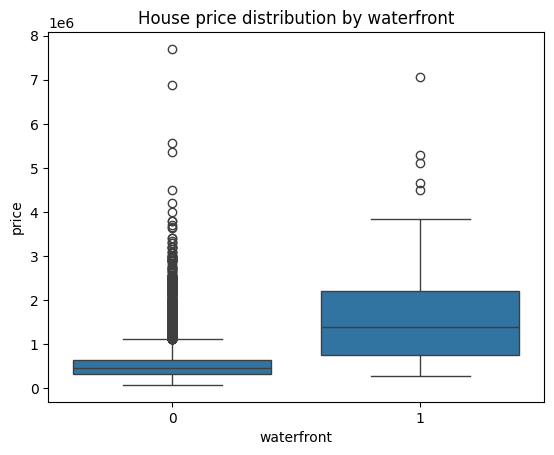

In [6]:
# Price distribution by waterfront vs. non-waterfront properties
sns.boxplot(x='waterfront', y='price', data=df)
plt.title("House price distribution by waterfront")
plt.show()


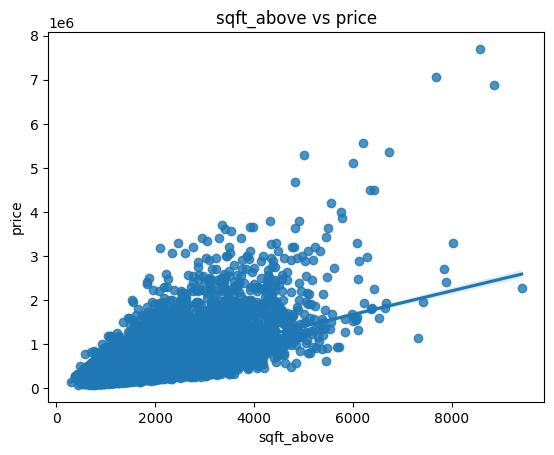

In [7]:
# Relationship between above-ground square footage and price
sns.regplot(x='sqft_above', y='price', data=df)
plt.title("sqft_above vs price")
plt.show()


In [8]:
# Correlation of numerical features with price
corr_with_price = df.corr(numeric_only=True)['price'].sort_values(ascending=False)
corr_with_price


,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525738
view,0.397293
sqft_basement,0.323816
bedrooms,0.308797
lat,0.307003


## 6. Model development

We start with a simple linear regression model, then move to a multivariate model using several predictive features.

In [9]:
# Simple linear regression using sqft_living as the only predictor
lm_simple = LinearRegression()

X_simple = df[['sqft_living']]
y = df['price']

lm_simple.fit(X_simple, y)
r2_simple = lm_simple.score(X_simple, y)
print(f"R^2 (simple model with sqft_living): {r2_simple:.3f}")


R^2 (simple model with sqft_living): 0.493


In [10]:
# Multivariate linear regression with a richer set of features
features = [
    "floors",
    "waterfront",
    "lat",
    "bedrooms",
    "sqft_basement",
    "view",
    "bathrooms",
    "sqft_living15",
    "sqft_above",
    "grade",
    "sqft_living",
]

# Keep only features that actually exist in the dataframe
features = [f for f in features if f in df.columns]

X = df[features]
y = df['price']

lm_multi = LinearRegression()
lm_multi.fit(X, y)

r2_multi = lm_multi.score(X, y)
print("Features used:", features)
print(f"R^2 (multivariate model): {r2_multi:.3f}")


Features used: ['floors', 'waterfront', 'lat', 'bedrooms', 'sqft_basement', 'view', 'bathrooms', 'sqft_living15', 'sqft_above', 'grade', 'sqft_living']
R^2 (multivariate model): 0.658


In [11]:
# Pipeline: scaling + polynomial features + linear regression
poly_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression()),
])

cv_scores = cross_val_score(poly_pipeline, X, y, cv=5, scoring="r2")
print("Cross-validated R^2 (polynomial pipeline):")
print("Scores:", cv_scores)
print("Mean R^2:", cv_scores.mean())


Cross-validated R^2 (polynomial pipeline):
Scores: [0.7579299  0.73927768 0.71418938 0.70420051 0.73736513]
Mean R^2: 0.7305925203063015


## 7. Model evaluation and refinement

We evaluate the model using a train/test split and experiment with a Ridge regression model, with and without polynomial features.

In [12]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)

print("Number of training samples:", x_train.shape[0])
print("Number of test samples:", x_test.shape[0])


Number of training samples: 18371
Number of test samples: 3242


In [14]:
# Ridge regression on the original feature space
from sklearn.metrics import mean_squared_error
import numpy as np
ridge = Ridge(alpha=0.1)
ridge.fit(x_train, y_train)

y_test_pred = ridge.predict(x_test)

r2_ridge = r2_score(y_test, y_test_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R^2 (Ridge, test set): {r2_ridge:.3f}")
print(f"RMSE (Ridge, test set): {rmse_ridge:,.0f}")


R^2 (Ridge, test set): 0.648
RMSE (Ridge, test set): 227,395


In [16]:
# Ridge regression with polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

x_train_pr = poly.fit_transform(x_train)
x_test_pr = poly.transform(x_test)

ridge_poly = Ridge(alpha=0.1)
ridge_poly.fit(x_train_pr, y_train)

y_test_pred_poly = ridge_poly.predict(x_test_pr)

r2_ridge_poly = r2_score(y_test, y_test_pred_poly)
rmse_ridge_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

print(f"R^2 (Ridge + polynomial features, test set): {r2_ridge_poly:.3f}")
print(f"RMSE (Ridge + polynomial features, test set): {rmse_ridge_poly:,.0f}")


R^2 (Ridge + polynomial features, test set): 0.700
RMSE (Ridge + polynomial features, test set): 209,795


## 8. Conclusions

- We explored key drivers of house prices in King County, such as square footage, grade, and waterfront.
- A simple linear regression on `sqft_living` provides a baseline model.
- A multivariate model with several features significantly improves the R² score.
- Polynomial features combined with scaling and regularization (Ridge) can further improve performance while controlling overfitting.

This notebook is designed to be easy to run for visitors to the GitHub repository: it can download the dataset automatically if it is not already present locally.